<a href="https://colab.research.google.com/github/Kravty/MachineLearning/blob/main/GAN_Fashion_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> This notebooks uses simple model (in PyTorch) based on GAN (Generative Adversarial Networks) idea to create the set of fake images similar to the original Fashion MNIST dataset

<h4> Import of libraries


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from skimage.io import imread

<h4> Data preparation 

In [2]:
# ToTensor function scales data in the range 0 and 1
# Normalize function scales pixel values between -1 and +1 (better results)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

In [3]:
# Downloading the dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(f'Trainset has {len(train_dataset)} samples')

Trainset has 60000 samples


In [5]:
# Specifying batch size and creating data loader object
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

<h4> Building the model

In [6]:
# Discriminator model
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
)

In [7]:
# Generator model
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# Creating a folder for storing generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [11]:
# Function to scale images back to (0, 1) for saving and plotting purposes
def scale_image(img):
  out = (img + 1) / 2
  return out

<h4> Training the model


In [12]:
# Training loop

# Creating labels for real images
ones_ = torch.ones(batch_size, 1).to(device)
# Creating labels for fake images
zeros_ = torch.zeros(batch_size, 1).to(device)

# Variables for storing discriminator and generator losses
d_losses = []
g_losses = []

for epoch in range(500):
  # Only inputs are used
  # Targets are denoted "_" and not used
  for inputs, _ in data_loader:

    # Samples may not divide evenly by the batch size
    n = inputs.size(0)
    # Reshaping and move to GPU
    inputs = inputs.reshape(n, 784).to(device)

    # Setting lables to the correct size
    ones = ones_[:n]
    zeros = zeros_[:n]



    ### Training discriminator ###

    # Real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # Fake images
    # Creating noise of the latent size dimensions for the generator input
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)
    
    # Taking mean of both discriminator losses
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # Zero the gradients accumulated by PyTorch
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    # Gradient descent step of the discriminator
    d_loss.backward()
    d_optimizer.step()



    ### Train generator ###

    # Since generator has harder task than discriminator it will be trained twice per epoch
    # Generator has to generate all pixel values of an image
    # Discriminator task is binary classification - real or fake
    for _ in range(2):
      # Fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # Reversing the labels to learn generator how to trick the discriminator
      g_loss = criterion(fake_outputs, ones)


      # Zero the gradients accumulated by PyTorch
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()

      # Gradient descent step of the generator
      g_loss.backward()
      g_optimizer.step()

    # Saving the losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  # Printing training progress
  print(f"Epoch: {epoch+1}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # Using torchvision function to save images
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 1, d_loss: 0.6895073652267456, g_loss: 0.6611472368240356
Epoch: 2, d_loss: 0.6953473687171936, g_loss: 0.7120083570480347
Epoch: 3, d_loss: 0.6886358261108398, g_loss: 0.730135440826416
Epoch: 4, d_loss: 0.6910233497619629, g_loss: 0.6871805191040039
Epoch: 5, d_loss: 0.6954233646392822, g_loss: 0.6993138194084167
Epoch: 6, d_loss: 0.688453733921051, g_loss: 0.6959819793701172
Epoch: 7, d_loss: 0.6923612356185913, g_loss: 0.6920380592346191
Epoch: 8, d_loss: 0.690811812877655, g_loss: 0.6900243163108826
Epoch: 9, d_loss: 0.6922856569290161, g_loss: 0.6908261775970459
Epoch: 10, d_loss: 0.6923822164535522, g_loss: 0.6965684294700623
Epoch: 11, d_loss: 0.6939080357551575, g_loss: 0.6897403597831726
Epoch: 12, d_loss: 0.6979806423187256, g_loss: 0.70644611120224
Epoch: 13, d_loss: 0.6924862265586853, g_loss: 0.7082657814025879
Epoch: 14, d_loss: 0.6987836360931396, g_loss: 0.6954050064086914
Epoch: 15, d_loss: 0.6987898945808411, g_loss: 0.6832556128501892
Epoch: 16, d_loss: 0.693

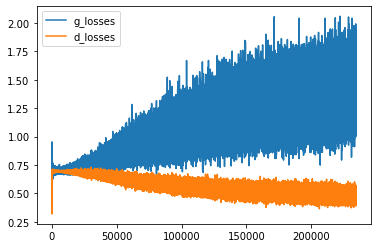

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

<h4> Plotting the generated images

Generated image after 1 epoch


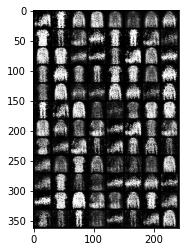

In [14]:
print('Generated image after 1 epoch')
im = imread('gan_images/1.png')
plt.imshow(im);

Generated image after 50 epochs


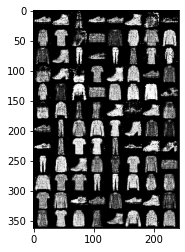

In [15]:
print('Generated image after 50 epochs')
im = imread('gan_images/50.png')
plt.imshow(im);

Generated image after 100 epochs


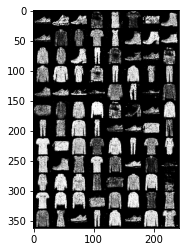

In [16]:
print('Generated image after 100 epochs')
im = imread('gan_images/100.png')
plt.imshow(im);

Generated image after 150 epochs


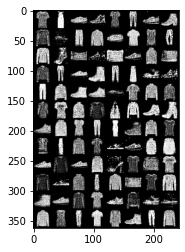

In [17]:
print('Generated image after 150 epochs')
im = imread('gan_images/150.png')
plt.imshow(im);

Generated image after 200 epochs


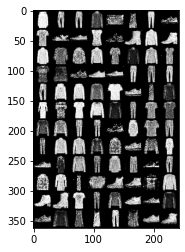

In [18]:
print('Generated image after 200 epochs')
im = imread('gan_images/200.png')
plt.imshow(im);

Generated image after 300 epochs


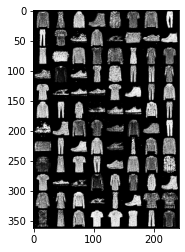

In [19]:
print('Generated image after 300 epochs')
im = imread('gan_images/300.png')
plt.imshow(im);

Generated image after 500 epochs


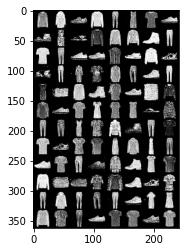

In [20]:
print('Generated image after 500 epochs')
im = imread('gan_images/500.png')
plt.imshow(im);